In [23]:
"""
Finite element solver for the 1D viscous Burgers' equation using Fenics
"""

"\nFinite element solver for the 1D viscous Burgers' equation using Fenics\n"

In [24]:
import dolfin as df 
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt
import matplotlib
import time
import scipy.io
import json
import sys
sys.path.append('..')
import os
#matplotlib.use('agg')

In [25]:
def mkdirs(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [26]:
class PeriodicBoundary1D(df.SubDomain):
    # https://fenicsproject.org/docs/dolfin/1.4.0/python/demo/documented/periodic/python/documentation.html
    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        return bool(df.near(x[0], 0) and on_boundary)

    # Map right boundary (H) to left boundary (G)
    def map(self, x, y):
        y[0] = x[0] - 1.0

In [27]:
def init_field_fenics(mesh, V, order=3, seed=None):
    # https://fenicsproject.org/qa/3975/interpolating-vector-function-from-python-code-to-fenics/

    u0 = df.Function(V)
    # Extract x and y coordinates of mesh and
    # align with dof structure
    dim = V.dim()
    N = mesh.geometry().dim()
    coor = V.tabulate_dof_coordinates().reshape(dim, N)
    dofs_V = V.dofmap().dofs()
    x = coor[:, 0]
    x_f = x[dofs_V]

    np.random.seed(seed)
    lam = np.random.randn(2, 2*order+1)
    c = np.random.rand() - 0.5
    k = np.arange(-order, order+1)
    kx = np.outer(k, x_f)*2*np.pi

    # vector field
    f = np.dot(lam[[0]], np.cos(kx)) + np.dot(lam[[1]], np.sin(kx))
    f = 2 * f / np.amax(np.abs(f)) + 2.0*c

    # Insert values of f into the function u0
    u0.vector()[dofs_V] = f[0]

    return u0, lam, c

In [28]:
def burgers1d(run, nu, ng, dt, T, ng_out, save_dir, save_every=1, order=3, plot=False):
    """simulate 1D Burgers' equation
    https://www.firedrakeproject.org/demos/burgers.py.html
    Args:
        run (int): # run
        nu (float): viscosity
        ng (int): # grid (vertices)
        dt (float): time step for simulation
        T (float): simulation time from 0 to T
        ng_out (int): output # grid
        save_dir (str): runs folder
        order (int): order for sampling initial U
        save_every (int): save frequency in terms of # dt
        save_pvd (bool): save the field as vtk file for paraview
        save_vector (bool): save fenics field vector for later operation
        plot (bool): plot fields
    """
    df.set_log_level(30)
    print('set_log_level',df)

    mesh = df.UnitIntervalMesh(ng)
    mesh_out = df.UnitIntervalMesh(ng_out)
    V = df.FunctionSpace(mesh, 'CG', 2, constrained_domain=PeriodicBoundary1D())
    Vout = df.FunctionSpace(mesh_out, 'CG', 1, constrained_domain=PeriodicBoundary1D())

    # initial vector field
    u0, lam, c = init_field_fenics(mesh, V, order=order, seed=run)
    np.savez(save_dir + f'/init_lam_c_{run}.npz', lam=lam, c=c)

    u = df.Function(V)
    u_old = df.Function(V)
    v = df.TestFunction(V)

    u = df.project(u0, V)
    u_old.assign(u)

    # backward Euler    
    F = (df.inner((u - u_old)/dt, v) \
        + df.inner(u*u.dx(0), v) \
        + nu*df.inner(df.grad(u), df.grad(v)))*df.dx

    t = 0
    k = 0

    u_save = []
    u_out = df.project(u, Vout)
    u_out_vertex = u_out.compute_vertex_values(mesh_out)
    u_save.append(u_out_vertex)

    tic = time.time()
    while t < T:

        t += dt
        k += 1
        df.solve(F == 0, u)
        u_old.assign(u)
        
        if k % save_every == 0:
            u_out = df.project(u, Vout)
            u_out_vertex = u_out.compute_vertex_values(mesh_out)
            u_save.append(u_out_vertex)
        # if k < 200 and k % 10 == 0:
        #     plt.plot(u_out_vertex)
        #     plt.savefig(save_dir + f'/run{run}_step{k}.pdf')
        #     plt.close()

    time_taken = time.time() - tic
    print(f'Run {run}: solved {k} steps with total {time_taken:.3f} seconds')
    u_save = np.stack(u_save, 0)
    print(u_save.shape)
    np.save(save_dir + f'/u{run}.npy', u_save)
    if plot:
        fig, ax = plt.subplots()
        cax = ax.imshow(u_save.T, origin='lower', cmap='inferno')
        ax.set_xlabel('x')
        ax.set_ylabel('t')
        plt.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
        plt.savefig(save_dir + f'/u{run}.png', dpi=300)
        plt.close()

    return run, time_taken

if __name__ == '__main__':

    import argparse
    parser = argparse.ArgumentParser(description='Sim 1D Burgers equation')
    parser.add_argument('--istart', type=int, default=0, help='start index (default: 0)')
    parser.add_argument('--iend', type=int, default=200, help='start index (default: 200)')
    parser.add_argument('--processes', type=int, default=4, help='# processes (default: 4)')
    args = parser.parse_args()

    args.ng = 512
    args.ng_out = 512
    args.nu = 0.0025
    args.dt = 0.001
    args.T = 2.0
    args.save_every = 1
    args.order = 4
    args.plot = False
    args.hardware = cpuinfo.cpu.info[0]['model name']
    args.save_dir = f'./fenics_data_dt{args.dt}_T{args.T}'

    mkdirs(args.save_dir)
    with open(args.save_dir + "/args.txt", 'w') as args_file:
        json.dump(vars(args), args_file, indent=4)

    pool = mp.Pool(processes=args.processes)
    print(f'Initialized pool with {args.processes} processes')
    results = [pool.apply_async(burgers1d, args=(run, args.nu, args.ng, args.dt, args.T, args.ng_out, 
        args.save_dir, args.save_every, args.order, args.plot)) for run in range(args.istart, args.iend)]
    time_taken = np.array([p.get() for p in results])

    np.save(args.save_dir+f'/ufenicsTimes_dt{args.dt}_T{args.T}.npy', time_taken)
    print(time_taken)

In [29]:
ng = 512
ng_out = 512
nu = 0.0025
dt = 0.001
T = 2.0
save_every = 1
order = 4
plot = False
save_dir = f'./fenics_data_dt{dt}_T{T}'

In [30]:
mkdirs(save_dir)
burgers1d(1, nu, ng, dt, T, ng_out, save_dir, save_every=1, order=3, plot=True)

set_log_level <module 'dolfin' from '/usr/local/lib/python3.6/dist-packages/dolfin/__init__.py'>
Run 1: solved 2001 steps with total 33.945 seconds
(2002, 513)


(1, 33.94478750228882)

In [31]:
data = np.load('fenics_data_dt0.001_T2.0/u1.npy')

In [32]:
import matplotlib.pyplot as plt

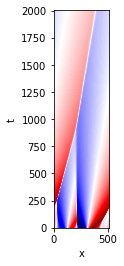

In [34]:
fig, ax = plt.subplots()
ax.imshow(data, origin='lower', cmap='seismic')
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.show()